In [1]:
from common import Fonts, Images, NWSL, Colors, add_twitter_handle, add_source
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from svgpath2mpl import parse_path
from scipy.interpolate import interp1d

In [11]:
df = pd.read_csv("data/teams.csv",index_col=[0])
df.columns = df.columns.astype(int)
df

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
team,,,,,,,,,,,,,,,
Boston Breakers,BOS,BOS,BOS,BOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FC Kansas City,KC,KC,KC,KC,UTA,UTA,UTA,UTA,KCC,KCC,KCC,KCC,KCC,KCC,KCC
Chicago Red Stars,CHI,NaN,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI
Portland Thorns,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR
Seattle Reign,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN
Sky Blue FC,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY
Washington Spirit,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS
Western New York Flash,WNY,WNY,WNY,WNY,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC
Houston Dash,NaN,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU


In [12]:
# Gather the list of cities for the y-axis
cities = pd.read_csv("data/cities.csv")


def city_to_y(c):
    if c == "KCC":
        c = "KC"
    elif c == "B2":
        c = "BOS"
    return cities[cities["city"] == c].index[0]


cities

,city,name
0,POR,Portland
1,WNY,Rochester
2,NC,North Carolina
3,KC,Kansas City
4,UTA,Salt Lake City
5,WAS,Washington DC
6,NJNY,New Jersey
7,RGN,Seattle
8,CHI,Chicago
9,BOS,Boston


In [13]:
# Gather the list of years for the x-axis
years = df.columns
years

Int64Index([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
            2024, 2025, 2026, 2027],
           dtype='int64')

In [14]:
# Gather name labels
names = pd.read_csv("data/names.csv")
names["city_index"] = names["city"].apply(city_to_y)
names

,city,year,name,city_index
0,BOS,2013,Boston Breakers,9
1,KC,2013,FC Kansas City,3
2,CHI,2013,Chicago Red Stars,8
3,POR,2013,Portland Thorns,0
4,RGN,2013,Seattle Reign,7
5,NJNY,2013,Sky Blue FC,6
6,WAS,2013,Washington Spirit,5
7,WNY,2013,Western New York Flash,1
8,HOU,2014,Houston Dash,10
9,ORL,2016,Orlando Pride,11


In [15]:
# Get the list of winners of different awards
winners = pd.read_csv("data/winners.csv", index_col=[0])
for col in winners.columns:
    winners[col + "_index"] = winners[col].apply(
        lambda val: val if pd.isnull(val) else city_to_y(val)
    )

winners = winners.reset_index()

champion = (
    winners[["year", "champion_index"]]
    .dropna()
    .rename(columns={"champion_index": "team"})
)
shield = (
    winners[["year", "shield_index"]].dropna().rename(columns={"shield_index": "team"})
)
cups = (
    winners[["year", "challenge_cup_index"]]
    .dropna()
    .rename(columns={"challenge_cup_index": "team"})
    .append(
        winners[["year", "fall_series_index"]]
        .dropna()
        .rename(columns={"fall_series_index": "team"})
    )
)

In [16]:
# Helpers to interpolate lines as curves
def interpolate_base(cubic_p):
    x1 = 0
    y1 = 0
    x2 = 1
    y2 = 1
    steps = np.linspace(0, cubic_p, 20)
    x = list(map(lambda i: x1 + i, steps)) + list(map(lambda i: x2 - i, steps[::-1]))
    y = [y1] * len(steps) + [y2] * len(steps)
    f = interp1d(x, y, kind="quadratic")
    xs = np.linspace(x1, x2, num=40)
    ys = f(xs)

    return (xs, ys)


def interpolate(x1, y1, x2, y2):
    (xs, ys) = interpolate_base(0.1)
    for i in range(0, len(xs)):
        xs[i] = x1 + xs[i] * (x2 - x1)
        ys[i] = y1 + ys[i] * (y2 - y1)

    return (xs, ys)


def to_points(x, y):
    c = list(map(lambda a: NWSL.color(a), y))
    y = list(map(city_to_y, y))

    x2, y2, c2 = [], [], []
    for xi, yi, ci in zip(x, y, c):
        if len(x2) == 0:
            x2.append(xi)
            y2.append(yi)
            c2.append(ci)
        else:
            xs, ys = interpolate(x2[-1], y2[-1], xi, yi)
            x2.extend(xs)
            y2.extend(ys)
            c2.extend([ci if i > len(xs) * 0.5 else c2[-1] for i in range(0, len(xs))])
    return (x2, y2, c2)

In [17]:
# Generate paths for the shield and trophy
shield_path = parse_path(open("data/shield.txt", "r").read())
shield_path = shield_path.transformed(mpl.transforms.Affine2D().rotate_deg(180).translate(480, -470))

trophy_path = parse_path(open("data/trophy.txt", "r").read())
trophy_path = trophy_path.transformed(mpl.transforms.Affine2D().rotate_deg(180).translate(480, -400))

<Figure size 6400x4000 with 0 Axes>

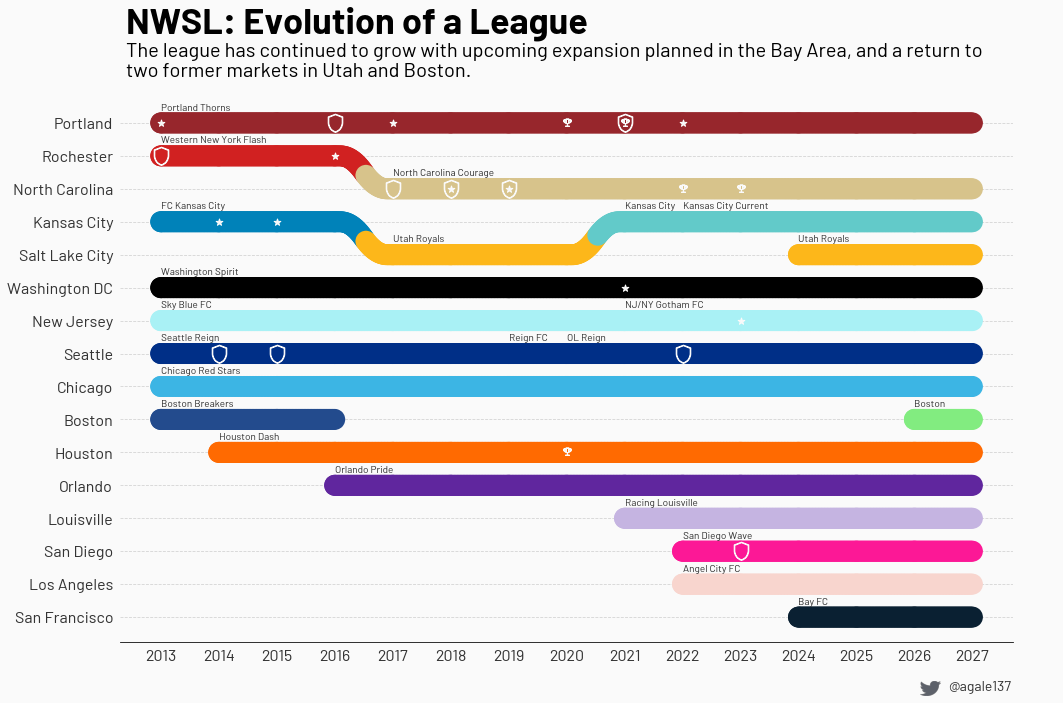

In [19]:
# Setup
plt.rcParams["figure.figsize"] = (16, 10)
plt.figure(dpi=400)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot data
for i, row in df.iterrows():
    row = row.dropna()
    x, y, c = to_points(row.index, row.values)
    ax.scatter(x, y, color=c, lw=15)

# Add team names
for i, row in names.iterrows():
    ax.text(
        row["year"],
        row["city_index"] - 0.4,
        row["name"],
        fontproperties=Fonts.BARLOW,
        color=Colors.BLACK,
    )

# Add trophies and awards
ax.scatter(champion["year"], champion["team"], color=Colors.WHITE, marker="*", s=50)
ax.scatter(
    shield["year"], shield["team"], color=Colors.WHITE, marker=shield_path, s=350
)
ax.scatter(cups["year"], cups["team"], color=Colors.WHITE, marker=trophy_path, s=80)

# Add axes
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)

ax.set_xticks(years)
ax.set_xticklabels(
    years,
    fontproperties=Fonts.BARLOW,
    size=16,
    color=Colors.BLACK,
)

ax.set_yticks(cities.index)
ax.set_yticklabels(
    cities["name"],
    fontproperties=Fonts.BARLOW,
    size=16,
    color=Colors.BLACK,
)
ax.invert_yaxis()
ax.yaxis.grid(True, color=Colors.LIGHT_GRAY, linestyle="--")

# Title
plt.figtext(
    0.13,
    0.97,
    "NWSL: Evolution of a League",
    fontproperties=Fonts.BARLOW_BOLD,
    size=36,
    ha="left",
)

# Subtitle
plt.figtext(
    0.13,
    0.91,
    "The league has continued to grow with upcoming expansion planned in the Bay Area, and a return to\ntwo former markets in Utah and Boston.",
    fontproperties=Fonts.BARLOW,
    size=20,
    ha="left",
)

# Save image
add_twitter_handle(fig, x=0.815, y=0.05, fs=14, w=0.023)
plt.savefig("nwsl_evolution.png", bbox_inches="tight", pad_inches=0.5, dpi=400)